## CNN-LSTM IoMT IDS
### CSCI 6505 Group Project
### Author: Hongwei Zhang & Koil Jat Chong
### Enhancing Intrusion Detection in Healthcare IoMT Devices Using the CNN-LSTM Model

### Preprocessing of [CIC IoMT dataset 2024](https://www.unb.ca/cic/datasets/iomt-dataset-2024.html)

In [39]:
import sys
import os
import pandas as pd
import torch
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
print("Python version:", sys.version)
print("Version info:", sys.version_info)

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Version info: sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:
# Read the dataset files list
file_list = pd.read_csv('./dataset/file_list.csv')
file_list.head()

,File,Category,Attack,Class
0,ARP_Spoofing_train.pcap.csv,SPOOFING,ARP Spoofing,1
1,Benign_train.pcap.csv,BENIGN,Benign,0
2,MQTT-DDoS-Connect_Flood_train.pcap.csv,MQTT,DDoS Connect Flood,1
3,MQTT-DDoS-Publish_Flood_train.pcap.csv,MQTT,DDoS Publish Flood,1
4,MQTT-DoS-Connect_Flood_train.pcap.csv,MQTT,DoS Connect Flood,1


In [3]:
# Import the dataset
data_dir = "./dataset/"
first_file_path = os.path.join(data_dir, file_list.iloc[0]['File'])
column_names = pd.read_csv(first_file_path, nrows=0).columns.tolist()

datasets_list = [] 
for _, row in file_list.iterrows():
    file_path = os.path.join(data_dir, row['File'])
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, header=None, skiprows=1, names=column_names)
        data['Category'] = row['Category']
        data['Attack'] = row['Attack']
        data['Class'] = row['Class']
        datasets_list.append(data)
    else:
        print(f"File not found: {file_path}")

# Combine all datasets into a single DataFrame
dataset = pd.concat(datasets_list, ignore_index=True)
dataset

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category,Attack,Class
0,866.600000,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,5.500000,16.963645,213.095221,66236.076476,0.900000,38.500000,SPOOFING,ARP Spoofing,1
1,3934.300000,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,13.500000,30.885371,708.919620,251721.126817,1.000000,244.600000,SPOOFING,ARP Spoofing,1
2,5592.800000,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,1.361110e-02,5.500000,21.787095,290.694475,84028.647525,0.900000,38.500000,SPOOFING,ARP Spoofing,1
3,9303.600000,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,1.694026e+08,13.500000,26.954506,597.046005,178453.001691,1.000000,244.600000,SPOOFING,ARP Spoofing,1
4,8592.400000,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,1.393099e-02,5.500000,24.255148,375.324132,80115.110731,0.900000,38.500000,SPOOFING,ARP Spoofing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160826,13234.910000,17.0,64.0,29460.045053,29460.045053,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.164175,8.453393,279.410488,0.130000,141.550000,DoS,DoS UDP,1
7160827,18136.530000,17.0,64.0,29318.535060,29318.535060,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.060924,3.012129,35.475423,0.130000,141.550000,DoS,DoS UDP,1
7160828,23038.040000,17.0,64.0,29363.556139,29363.556139,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.075262,3.287396,34.963050,0.160000,141.550000,DoS,DoS UDP,1
7160829,58526.160000,17.0,64.0,26168.955034,26168.955034,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,18.631072,205.641671,70932.249555,0.350000,141.550000,DoS,DoS UDP,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160831 entries, 0 to 7160830
Data columns (total 48 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    float64
 2   Duration         float64
 3   Rate             float64
 4   Srate            float64
 5   Drate            float64
 6   fin_flag_number  float64
 7   syn_flag_number  float64
 8   rst_flag_number  float64
 9   psh_flag_number  float64
 10  ack_flag_number  float64
 11  ece_flag_number  float64
 12  cwr_flag_number  float64
 13  ack_count        float64
 14  syn_count        float64
 15  fin_count        float64
 16  rst_count        float64
 17  HTTP             float64
 18  HTTPS            float64
 19  DNS              float64
 20  Telnet           float64
 21  SMTP             float64
 22  SSH              float64
 23  IRC              float64
 24  TCP              float64
 25  UDP              float64
 26  DHCP             float64
 27  ARP         

In [5]:
dataset.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
count,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7160831.0,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,...,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06
mean,2.958836e+04,8.042957e+00,6.474653e+01,1.523202e+04,1.523202e+04,0.0,5.079549e-03,1.587609e-01,3.862139e-02,2.240655e-02,...,6.405743e+00,6.084036e+01,8.468349e+07,9.499081e+00,1.045008e+01,9.047367e+00,2.535226e+03,9.148464e-02,1.415273e+02,9.730852e-01
std,2.762618e+05,6.292201e+00,8.405262e+00,3.950968e+04,3.950968e+04,0.0,3.411170e-02,3.388233e-01,1.371016e-01,9.713147e-02,...,3.917360e+01,8.787628e+01,1.788442e+07,8.446717e-01,3.169197e+00,5.538149e+01,2.045832e+04,2.327133e-01,2.174138e+01,1.618343e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,-1.282061e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.400000e+01,1.160000e+00,6.400000e+01,6.685014e+00,6.685014e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.258000e+01,8.467888e+07,9.500000e+00,9.199377e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
50%,1.080000e+02,6.000000e+00,6.400000e+01,1.452887e+02,1.452887e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.469641e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
75%,1.958050e+04,1.700000e+01,6.400000e+01,1.914681e+04,1.914681e+04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.469686e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
max,9.895636e+06,1.700000e+01,2.550000e+02,2.097152e+06,2.097152e+06,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,7.211509e+02,1.514000e+03,1.694694e+08,1.500000e+01,5.502727e+01,1.020232e+03,5.204379e+05,1.000000e+00,2.446000e+02,1.000000e+00


In [6]:
# Function to create barplot
def barplot_show(data, column, width=8):
    plt.figure(figsize=(width, 6))
    barplot = sb.barplot(
        y=data[column].value_counts().values, 
        x=data[column].value_counts().index, 
        palette="Spectral")
    barplot.set(xlabel=column, ylabel='Number of Samples')
    for p in barplot.patches:
        barplot.annotate(format(int(p.get_height()), 'd'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.show()

In [7]:
dataset['Category'].value_counts()

Category
DDoS        4779859
DoS         1805529
MQTT         262938
BENIGN       192732
RECON        103726
SPOOFING      16047
Name: count, dtype: int64

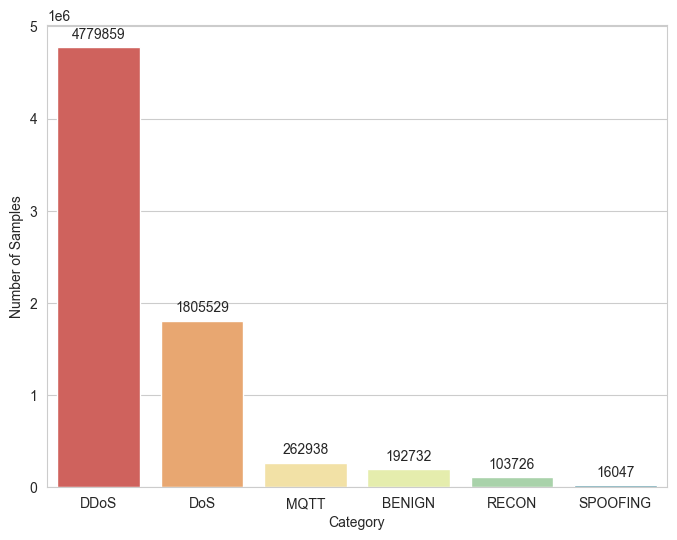

In [8]:
barplot_show(dataset, 'Category')

In [9]:
dataset['Attack'].value_counts()

Attack
DDoS UDP              1635956
DDoS ICMP             1537476
DDoS TCP               804465
DDoS SYN               801962
DoS UDP                566950
DoS SYN                441903
DoS ICMP               416292
DoS TCP                380384
Benign                 192732
DDoS Connect Flood     173036
Port Scan               83981
DoS Publish Flood       44376
DDoS Publish Flood      27623
OS Scan                 16832
ARP Spoofing            16047
DoS Connect Flood       12773
Malformed Data           5130
VulScan                  2173
Ping Sweep                740
Name: count, dtype: int64

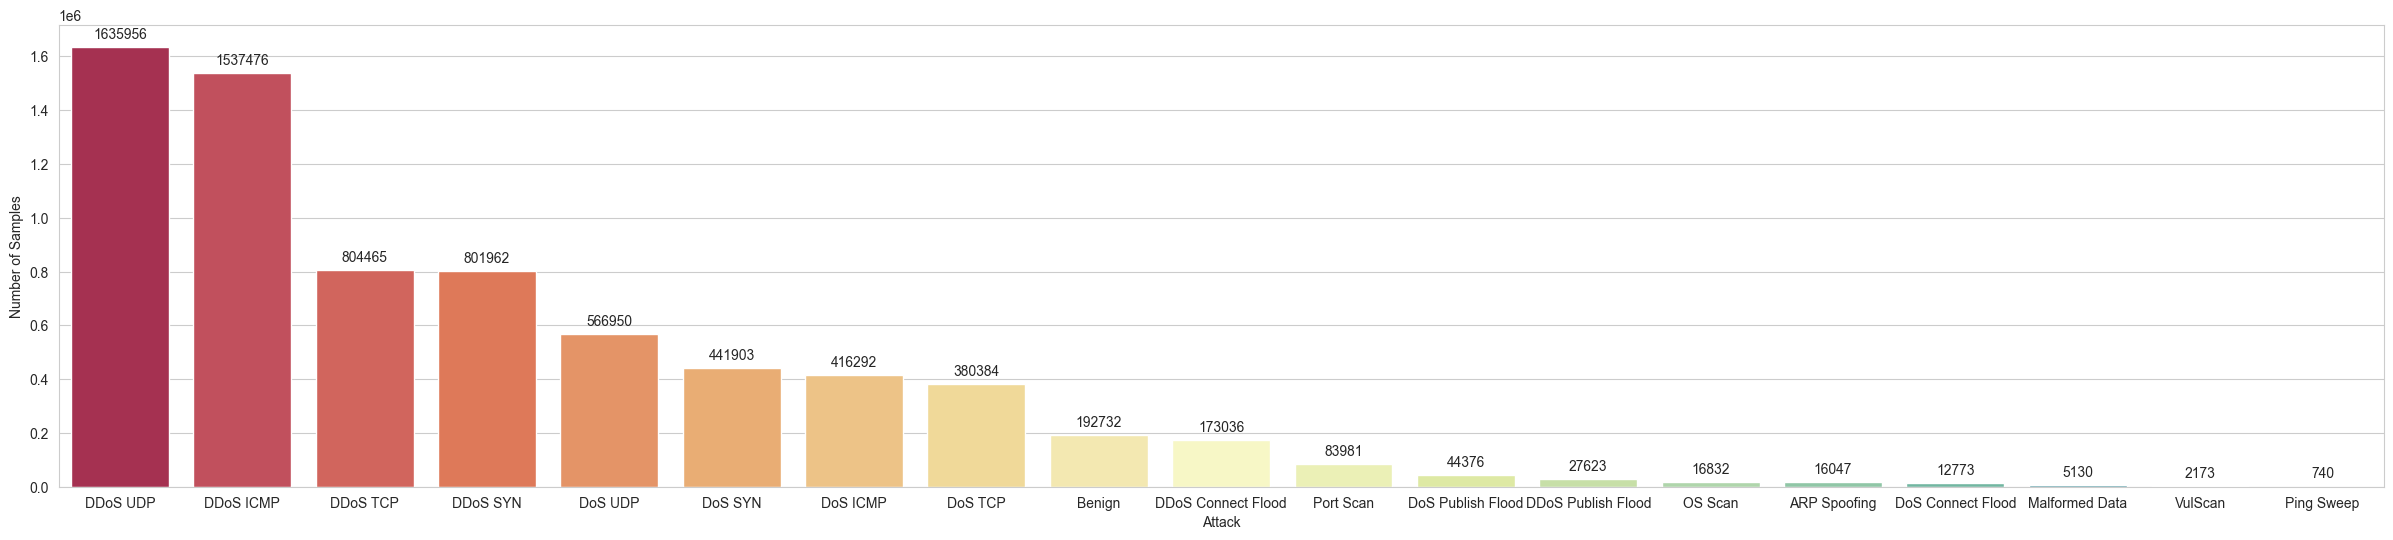

In [10]:
barplot_show(dataset, 'Attack', width=30)

In [11]:
dataset['Class'].value_counts()

Class
1    6968099
0     192732
Name: count, dtype: int64

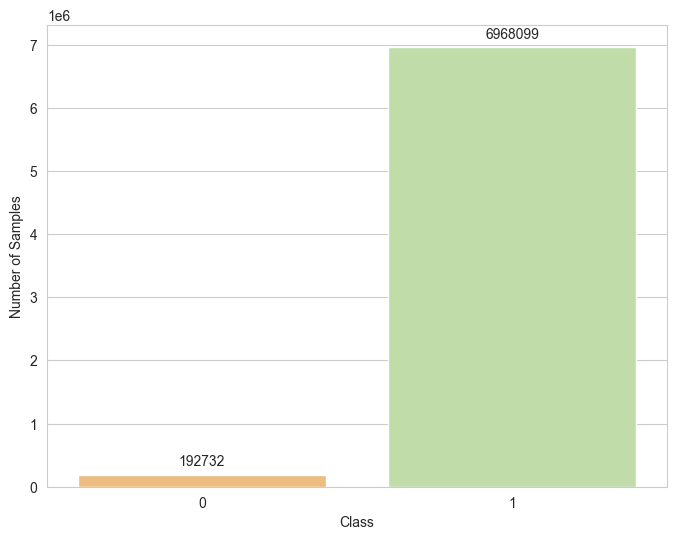

In [12]:
barplot_show(dataset, 'Class', width=8)

In [13]:
# Select 'Category' to perform multiclass classification
selected_data = dataset.iloc[:, :46]
selected_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category
0,866.6,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,150.681076,431.8,1.694026e+08,5.5,16.963645,213.095221,66236.076476,0.9,38.5,SPOOFING
1,3934.3,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,500.702909,406.3,1.694026e+08,13.5,30.885371,708.919620,251721.126817,1.0,244.6,SPOOFING
2,5592.8,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,205.552035,386.6,1.361110e-02,5.5,21.787095,290.694475,84028.647525,0.9,38.5,SPOOFING
3,9303.6,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,421.683660,300.2,1.694026e+08,13.5,26.954506,597.046005,178453.001691,1.0,244.6,SPOOFING
4,8592.4,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,265.394239,209.2,1.393099e-02,5.5,24.255148,375.324132,80115.110731,0.9,38.5,SPOOFING


In [22]:
# Over sampling
samples = 200000
categories = ['SPOOFING', 'BENIGN', 'MQTT', 'RECON', 'DDoS', 'DoS']

X = selected_data.iloc[:, :-1]
y = selected_data.iloc[:, -1]
class_counts = Counter(y)

# Sampling strategies
smote_strategy = {}
undersample_strategy = {}
for category, count in class_counts.items():
    if count < samples:
        smote_strategy[category] = samples
    elif count > samples:
        undersample_strategy[category] = samples
print("SMOTE strategy:", smote_strategy)
print("Undersample strategy:", undersample_strategy)

# SMOTE
if smote_strategy:
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
else:
    X_smote, y_smote = X, y
    
smote_data = pd.DataFrame(X_smote, columns=X.columns)
smote_data['Target'] = y_smote

# Random under sampling
if undersample_strategy:
    undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
    X_balanced, y_balanced = undersampler.fit_resample(smote_data.iloc[:, :-1], smote_data['Target'])
else:
    X_balanced, y_balanced = smote_data.iloc[:, :-1], smote_data['Target']

processed_data = pd.DataFrame(X_balanced, columns=X.columns)
processed_data['Target'] = y_balanced

SMOTE strategy: {'SPOOFING': 200000, 'BENIGN': 200000, 'RECON': 200000}
Undersample strategy: {'MQTT': 200000, 'DDoS': 200000, 'DoS': 200000}


In [23]:
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
16047,134.3,7.1,64.0,40415.288318,40415.288318,0.0,0.0,0.0,0.0,0.5,...,48.225852,95.3,1.694641e+08,5.5,15.312231,68.201654,2644.242675,0.9,38.5,BENIGN
16048,137.0,4.7,49.9,58749.191833,58749.191833,0.0,0.0,0.0,0.0,0.2,...,59.753361,125.6,1.694641e+08,13.5,13.468364,84.997147,5328.483794,1.0,244.6,BENIGN
16049,283.9,6.0,64.0,3.497439,3.497439,0.0,0.0,0.0,0.0,0.5,...,10.223690,80.6,8.070469e-05,5.5,12.229315,14.458481,124.725884,0.9,38.5,BENIGN
16050,297.3,6.0,64.0,7297.703020,7297.703020,0.0,0.0,0.0,0.0,0.5,...,15.625023,78.5,1.694641e+08,13.5,12.552920,21.904691,240.536207,1.0,244.6,BENIGN
16051,572.3,7.1,57.7,2.549120,2.549120,0.0,0.0,0.0,0.0,0.4,...,69.738867,139.0,9.993820e-02,5.5,13.928729,98.625651,11737.768847,0.9,38.5,BENIGN


In [24]:
processed_data['Target'].value_counts()

Target
BENIGN      200000
DDoS        200000
DoS         200000
MQTT        200000
RECON       200000
SPOOFING    200000
Name: count, dtype: int64

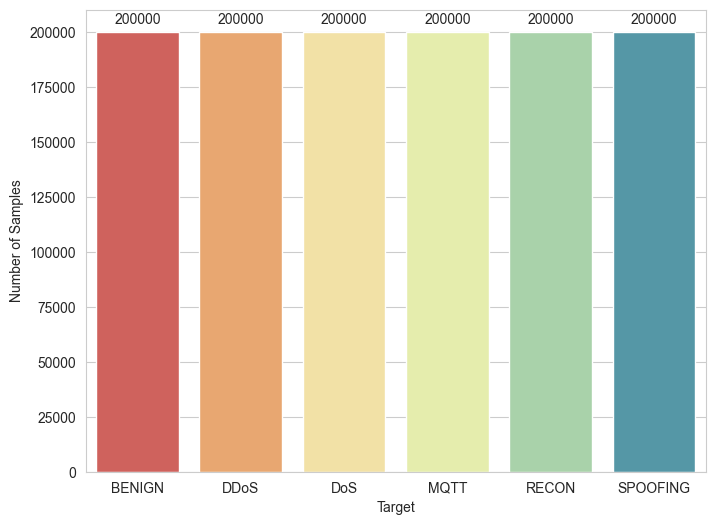

In [25]:
barplot_show(processed_data, 'Target')

In [26]:
# Encode the class labels
category_mapping = {
    'BENIGN': 0,
    'DDoS': 1,
    'DoS': 2,
    'MQTT': 3,
    'RECON': 4,
    'SPOOFING': 5
}
processed_data['Target'] = processed_data['Target'].map(category_mapping)
print(processed_data['Target'].unique())

[0 1 2 3 4 5]


In [27]:
# Normalize the data
scaler = MinMaxScaler()
normalize_data = processed_data.columns[:-1]
processed_data[normalize_data] = scaler.fit_transform(processed_data[normalize_data])
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
16047,0.000014,0.417647,0.250980,0.019272,0.019272,0.0,0.0,0.0,0.0,0.5,...,0.066873,0.036209,9.999685e-01,0.321429,0.134034,0.066849,0.005081,0.9,0.153941,0
16048,0.000014,0.276471,0.195686,0.028014,0.028014,0.0,0.0,0.0,0.0,0.2,...,0.082858,0.056793,9.999685e-01,0.892857,0.093829,0.083312,0.010238,1.0,1.000000,0
16049,0.000029,0.352941,0.250980,0.000002,0.000002,0.0,0.0,0.0,0.0,0.5,...,0.014177,0.026223,7.565624e-09,0.321429,0.066813,0.014172,0.000240,0.9,0.153941,0
16050,0.000030,0.352941,0.250980,0.003480,0.003480,0.0,0.0,0.0,0.0,0.5,...,0.021667,0.024796,9.999685e-01,0.892857,0.073869,0.021470,0.000462,1.0,1.000000,0
16051,0.000058,0.417647,0.226275,0.000001,0.000001,0.0,0.0,0.0,0.0,0.4,...,0.096705,0.065897,8.154860e-09,0.321429,0.103867,0.096670,0.022554,0.9,0.153941,0


In [28]:
# Shuffle the dataset
processed_data = processed_data.sample(frac=1).reset_index(drop=True)
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
0,0.002949,1.000000,0.25098,0.007023,0.007023,0.0,0.00,0.00,0.00,0.00,...,0.000000,0.005435,0.499777,0.607143,1.820345e-02,0.000000,0.000000,0.00,0.57697,1
1,0.004153,0.352941,0.25098,0.000025,0.000025,0.0,0.00,0.14,0.13,0.57,...,0.295687,0.192663,0.499600,0.607143,2.824814e-01,0.295016,0.194833,0.94,0.57697,3
2,0.001619,1.000000,0.25098,0.013645,0.013645,0.0,0.00,0.00,0.00,0.00,...,0.000000,0.005435,0.499776,0.607143,1.820345e-02,0.000000,0.000000,0.00,0.57697,1
3,0.000045,0.352941,0.25098,0.000004,0.000004,0.0,0.25,0.27,0.13,0.13,...,0.006503,0.017996,0.499601,0.607143,5.692759e-02,0.006497,0.000051,0.92,0.57697,3
4,0.000000,0.058824,0.25098,0.000001,0.000001,0.0,0.00,0.00,0.00,0.00,...,0.000000,0.000000,0.499778,0.607143,5.551115e-17,0.000000,0.000000,0.00,0.57697,1


In [30]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 46 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Header_Length    1200000 non-null  float64
 1   Protocol Type    1200000 non-null  float64
 2   Duration         1200000 non-null  float64
 3   Rate             1200000 non-null  float64
 4   Srate            1200000 non-null  float64
 5   Drate            1200000 non-null  float64
 6   fin_flag_number  1200000 non-null  float64
 7   syn_flag_number  1200000 non-null  float64
 8   rst_flag_number  1200000 non-null  float64
 9   psh_flag_number  1200000 non-null  float64
 10  ack_flag_number  1200000 non-null  float64
 11  ece_flag_number  1200000 non-null  float64
 12  cwr_flag_number  1200000 non-null  float64
 13  ack_count        1200000 non-null  float64
 14  syn_count        1200000 non-null  float64
 15  fin_count        1200000 non-null  float64
 16  rst_count        1

In [31]:
processed_data.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Target
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1200000.0,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,...,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,5.105056e-02,4.539512e-01,2.705137e-01,2.810933e-03,2.810933e-03,0.0,2.343682e-02,1.585255e-01,1.105081e-01,1.434499e-01,...,7.328933e-02,8.488319e-02,4.995861e-01,6.069556e-01,1.286951e-01,7.319335e-02,3.916639e-02,4.619139e-01,5.766940e-01,2.500000e+00
std,1.460747e-01,2.740230e-01,1.133267e-01,1.263204e-02,1.263204e-02,0.0,6.993068e-02,3.210561e-01,2.625284e-01,2.109158e-01,...,1.648427e-01,1.975886e-01,3.546528e-01,2.027154e-01,2.144392e-01,1.647874e-01,1.177546e-01,4.433397e-01,3.000881e-01,1.707826e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.091390e-05,3.529412e-01,2.509804e-01,1.789193e-06,1.789193e-06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,8.152174e-03,8.156528e-09,3.214286e-01,2.675745e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.539409e-01,1.000000e+00
50%,4.989371e-04,3.529412e-01,2.509804e-01,7.246519e-06,7.246519e-06,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.724379e-03,1.611413e-02,4.996491e-01,6.071429e-01,4.999576e-02,3.640039e-03,3.156719e-05,4.000000e-01,5.769704e-01,2.500000e+00
75%,1.078838e-02,4.176471e-01,2.509804e-01,7.116326e-05,7.116326e-05,0.0,0.000000e+00,1.100000e-01,0.000000e+00,2.700000e-01,...,2.952538e-02,3.301630e-02,9.991383e-01,8.928571e-01,9.197896e-02,2.899693e-02,1.590159e-03,9.000000e-01,1.000000e+00,4.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


### Model Creation and Training

In [32]:
# Extract features and labels
X = processed_data.drop(columns=['Target']).values
y = processed_data['Target'].values
print(f'X: {X.shape}, y: {y.shape}')

X: (1200000, 45), y: (1200000,)


In [33]:
# Split the data into train, validation, and test sets
# 70% training, 15% validation, 15% testing
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (840000, 45) (840000,)
Validation set: (180000, 45) (180000,)
Test set: (180000, 45) (180000,)


In [34]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create data loaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [35]:
# Define the model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNN_LSTM_Model, self).__init__()

        # CNN layer for extracting spatial features
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # LSTM layer for extracting temporal features
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(2)
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [36]:
# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 256
num_layers = 1
num_classes = 6

model = CNN_LSTM_Model(input_size, hidden_size, num_layers, num_classes)
print(model.to('cpu'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN_LSTM_Model(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


In [37]:
# Training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(dataloader.dataset)

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute additional metrics
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return running_loss / len(dataloader.dataset), accuracy, precision, recall, f1

In [38]:
# Train and evaluate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion)
    print(
        f"Epoch {epoch + 1}/{num_epochs}: <Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}, Val Prec: {val_prec:.6f}, Val Rec: {val_rec:.6f}, Val F1: {val_f1:.6f}>")

Epoch 1/10: <Train Loss: 0.393026, Val Loss: 0.341707, Val Acc: 0.822289, Val Prec: 0.829495, Val Rec: 0.822369, Val F1: 0.821869>
Epoch 2/10: <Train Loss: 0.337667, Val Loss: 0.327992, Val Acc: 0.828122, Val Prec: 0.832063, Val Rec: 0.828219, Val F1: 0.827692>
Epoch 3/10: <Train Loss: 0.320267, Val Loss: 0.313380, Val Acc: 0.835844, Val Prec: 0.838523, Val Rec: 0.835946, Val F1: 0.835760>
Epoch 4/10: <Train Loss: 0.309332, Val Loss: 0.303862, Val Acc: 0.840628, Val Prec: 0.843959, Val Rec: 0.840732, Val F1: 0.840062>
Epoch 5/10: <Train Loss: 0.301621, Val Loss: 0.299585, Val Acc: 0.842372, Val Prec: 0.846265, Val Rec: 0.842457, Val F1: 0.841989>
Epoch 6/10: <Train Loss: 0.295229, Val Loss: 0.289692, Val Acc: 0.850883, Val Prec: 0.852466, Val Rec: 0.850900, Val F1: 0.850936>
Epoch 7/10: <Train Loss: 0.285833, Val Loss: 0.287562, Val Acc: 0.855478, Val Prec: 0.856877, Val Rec: 0.855539, Val F1: 0.855726>
Epoch 8/10: <Train Loss: 0.278988, Val Loss: 0.278592, Val Acc: 0.861128, Val Prec:

In [40]:
# Evaluate on the test set
loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {loss:.6f}'
      f'\nAccuracy: {accuracy:.6f}'
      f'\nPrecision: {precision:.6f}'
      f'\nRecall: {recall:.6f}'
      f'\nF1-score: {f1:.6f}')

Test Loss: 0.276405
Accuracy: 0.860306
Precision: 0.861939
Recall: 0.860404
F1-score: 0.860691
